**Title & Objective**  
   “Predict next-month credit card default. Train, track (MLflow), register & serve a model; run batch + REST inference.”

In [ ]:
# Core
import os, time, json, re, warnings
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_recall_curve, auc, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# MLflow
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.models.signature import infer_signature

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

mlflow.set_tracking_uri("file://" + os.path.abspath("mlruns"))

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_registry_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_card_default_lab")
warnings.filterwarnings("ignore")

**Load Dataset (UCI Credit Card Default)**  
   “Read local `.xls`/`.csv`, normalize columns, preview shape & head.”

In [ ]:
#to Load Credit Card Default dataset (local file) 

import pandas as pd
import re

data_path = "data/default of credit card clients.xls"

df_raw = pd.read_excel(data_path, header=1)

# to clean column names
df_raw.columns = [re.sub(r"\s+", "_", c.strip()).lower() for c in df_raw.columns]

print("Shape:", df_raw.shape)
df_raw.head()

Shape: (30000, 25)


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Clean Target & Basic Checks**  
   “Rename target to `label`, drop ID columns, show label distribution.”

In [17]:
df = df_raw.copy()

# target
target_col = None
try:
    target_col = [c for c in df.columns if c.startswith("default")][0]
except:
    raise RuntimeError("Target column not found; inspect df.columns.")

# rename target to 'label'
df = df.rename(columns={target_col: "label"})

# Common ID column in some mirrors (drop if present)
for id_like in ["id", "unnamed:_0", "unnamed:0"]:
    if id_like in df.columns:
        df = df.drop(columns=[id_like])

print("Columns:", len(df.columns))
print("Label distribution:\n", df["label"].value_counts(normalize=True))
df.head()

Columns: 24
Label distribution:
 label
0    0.7788
1    0.2212
Name: proportion, dtype: float64


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,label
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Quick EDA**  
   “Visualize class imbalance and correlations (subset to keep plots readable).”

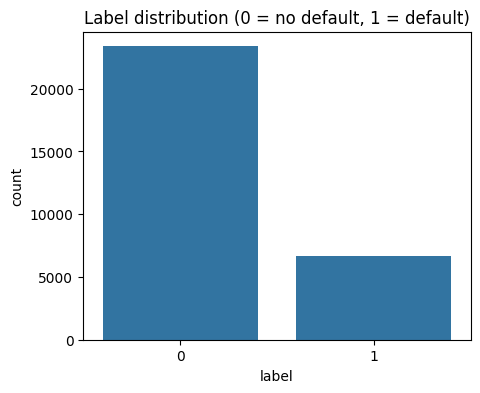

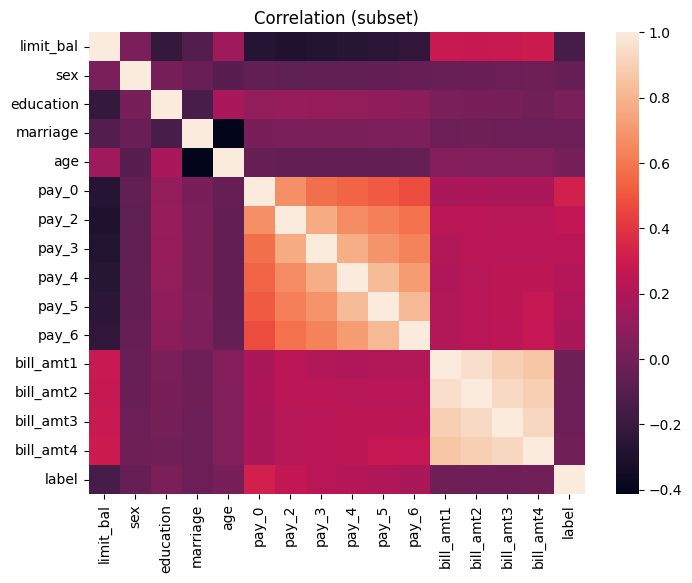

In [18]:
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df)
plt.title("Label distribution (0 = no default, 1 = default)")
plt.show()

# Correlation heatmap for a subset to keep it readable
subset_cols = [c for c in df.columns if c != "label"][:15]
corr = df[subset_cols + ["label"]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False)
plt.title("Correlation (subset)")
plt.show()

**Define Features**  
   “Categorical-like (`SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0..6`) vs numeric (limits/bills/payments/age).”

In [19]:
# some datasets name these PAY columns as pay_0..pay_6 after normalization
pay_cols = [c for c in df.columns if re.match(r"pay_[-]?\d+", c) or re.match(r"pay_\d+", c)]
if not pay_cols:
    # fall back to common names: pay_0..pay_6
    pay_cols = [f"pay_{i}" for i in range(0, 7) if f"pay_{i}" in df.columns]

cat_cols = []
for c in ["sex", "education", "marriage"]:
    if c in df.columns:
        cat_cols.append(c)
cat_cols += pay_cols

# ensure columns exist
cat_cols = [c for c in cat_cols if c in df.columns]

feature_cols = [c for c in df.columns if c != "label"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Categorical-like:", cat_cols[:10], "... total:", len(cat_cols))
print("Numeric:", num_cols[:10], "... total:", len(num_cols))

Categorical-like: ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] ... total: 9
Numeric: ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2'] ... total: 14


**Train/Val/Test Split**  
   “Stratified 60/20/20 with fixed `random_state`.”

In [20]:
X = df[feature_cols].copy()
y = df["label"].astype(int).copy()

X_train, X_rem, y_train, y_rem = train_test_split(
    X, y, train_size=0.6, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=RANDOM_STATE
)

X_train.shape, X_val.shape, X_test.shape

((18000, 23), (6000, 23), (6000, 23))

**Preprocessing Pipeline**  
   “`ColumnTransformer`: scale numeric, one-hot encode categorical.”

In [21]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

**Metrics Helper**  
   “Function to compute AUC, PR-AUC, Accuracy, F1, and confusion matrix.”

In [22]:
def evaluate_binary(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    roc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    cm = confusion_matrix(y_true, y_pred)
    return {"auc": roc, "accuracy": acc, "f1": f1, "pr_auc": pr_auc, "cm": cm.tolist()}

**Baseline Model: Logistic Regression (Balanced)**  
    “Train baseline, log params/metrics/model to MLflow.”

In [ ]:
class ProbModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, sk_pipeline):
        self.sk_pipeline = sk_pipeline
    def predict(self, context, model_input):
        return self.sk_pipeline.predict_proba(model_input)[:, 1]

with mlflow.start_run(run_name="baseline_logreg"):
    clf = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=None
        ))
    ])
    clf.fit(X_train, y_train)

    val_probs = clf.predict_proba(X_val)[:, 1]
    test_probs = clf.predict_proba(X_test)[:, 1]
    val_metrics = evaluate_binary(y_val, val_probs)
    test_metrics = evaluate_binary(y_test, test_probs)

    mlflow.log_param("model_type", "LogisticRegression_balanced")
    for k, v in val_metrics.items():
        if k != "cm":
            mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        if k != "cm":
            mlflow.log_metric(f"test_{k}", v)

    # to save confusion matrices as artifacts
    mlflow.log_text(json.dumps(val_metrics["cm"]), artifact_file="val_confusion_matrix.json")
    mlflow.log_text(json.dumps(test_metrics["cm"]), artifact_file="test_confusion_matrix.json")

    wrapped = ProbModelWrapper(clf)
    signature = infer_signature(X_train, wrapped.predict(None, X_train))

    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=wrapped,
        signature=signature
    )

    print("Validation:", {k: v for k, v in val_metrics.items() if k != "cm"})
    print("Test:", {k: v for k, v in test_metrics.items() if k != "cm"})

/Users/haber/Desktop/Tisha/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/credit_env/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/10/20 16:41:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Validation: {'auc': 0.7632502514484998, 'accuracy': 0.7701666666666667, 'f1': 0.5236614853195164, 'pr_auc': 0.5265295069999698}
Test: {'auc': 0.7783176486771398, 'accuracy': 0.7821666666666667, 'f1': 0.5453913043478261, 'pr_auc': 0.5535744616820278}
🏃 View run baseline_logreg at: http://127.0.0.1:5000/#/experiments/1/runs/7f4ea90ccaf5462ea4ebbcfef14676dd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


**Baseline Model: Logistic Regression (Balanced)**  
    “Train baseline, log params/metrics/model to MLflow.”

In [24]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])

param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    rf_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
grid.best_params_, grid.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 400},
 np.float64(0.7820731371369392))

**Log Best RF + Feature Importances**  
    “Log tuned metrics, importances, and model as pyfunc.”

In [25]:
with mlflow.start_run(run_name="rf_tuned_balanced"):
    val_probs = best_rf.predict_proba(X_val)[:, 1]
    test_probs = best_rf.predict_proba(X_test)[:, 1]
    val_metrics = evaluate_binary(y_val, val_probs)
    test_metrics = evaluate_binary(y_test, test_probs)

    mlflow.log_param("model_type", "RandomForest_balanced")
    mlflow.log_params(grid.best_params_)
    for k, v in val_metrics.items():
        if k != "cm": mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        if k != "cm": mlflow.log_metric(f"test_{k}", v)
    mlflow.log_text(json.dumps(val_metrics["cm"]), artifact_file="val_confusion_matrix.json")
    mlflow.log_text(json.dumps(test_metrics["cm"]), artifact_file="test_confusion_matrix.json")

    # Extract feature names after transform
    # Get names from ColumnTransformer
    ohe = best_rf.named_steps["prep"].named_transformers_["cat"]
    num_features = best_rf.named_steps["prep"].transformers_[0][2]  # numeric cols list
    cat_features = ohe.get_feature_names_out(best_rf.named_steps["prep"].transformers_[1][2]).tolist()
    all_features = list(num_features) + cat_features

    rf = best_rf.named_steps["clf"]
    importances = rf.feature_importances_
    feats = pd.DataFrame({"feature": all_features, "importance": importances}).sort_values("importance", ascending=False)
    mlflow.log_text(feats.to_csv(index=False), artifact_file="feature_importances.csv")

    # Log model
    class ProbModelWrapper(mlflow.pyfunc.PythonModel):
        def __init__(self, sk_pipeline):
            self.sk_pipeline = sk_pipeline
        def predict(self, context, model_input):
            return self.sk_pipeline.predict_proba(model_input)[:, 1]

    wrapped = ProbModelWrapper(best_rf)
    signature = infer_signature(X_train, wrapped.predict(None, X_train))
    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=wrapped,
        signature=signature
    )

    print("Best RF params:", grid.best_params_)
    print("Validation:", {k: v for k, v in val_metrics.items() if k != "cm"})
    print("Test:", {k: v for k, v in test_metrics.items() if k != "cm"})
    feats.head(15)


/Users/haber/Desktop/Tisha/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/credit_env/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/10/20 16:42:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best RF params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 400}
Validation: {'auc': 0.7746657795080882, 'accuracy': 0.7775, 'f1': 0.5346810735447891, 'pr_auc': 0.5466031422880703}
Test: {'auc': 0.7793992360351945, 'accuracy': 0.7793333333333333, 'f1': 0.5364145658263305, 'pr_auc': 0.5624267800341484}
🏃 View run rf_tuned_balanced at: http://127.0.0.1:5000/#/experiments/1/runs/877a1cc1e0f34568a1ab7472f2d99861
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


**Register Best Run to Model Registry**  
    “Register the top run’s model under `credit_default_classifier`.”

In [26]:
runs = mlflow.search_runs(order_by=["metrics.val_auc DESC"])
top_run = runs.iloc[0]
top_run_id = top_run.run_id
top_run_model_uri = f"runs:/{top_run_id}/model"

model_name = "credit_default_classifier"
print("Registering:", top_run_model_uri)
model_version = mlflow.register_model(top_run_model_uri, model_name)

# give registry time to finalize
time.sleep(10)
model_version.version

Successfully registered model 'credit_default_classifier'.
2025/10/20 16:42:25 WARNING mlflow.tracking._model_registry.fluent: Run with id 877a1cc1e0f34568a1ab7472f2d99861 has no artifacts at artifact path 'model', registering model based on models:/m-b641ecbaa13a4c3e8045668bcd721a0e instead
2025/10/20 16:42:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: credit_default_classifier, version 1


Registering: runs:/877a1cc1e0f34568a1ab7472f2d99861/model


Created version '1' of model 'credit_default_classifier'.


'1'

**Promote to Production**  
    “Transition the registered model version to the ‘Production’ stage.”

In [27]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",
)
print(f"Model {model_name} version {model_version.version} moved to Production.")

Model credit_default_classifier version 1 moved to Production.


 **Load Production Model & Sanity Check**  
    “Load from registry; compute AUC on test set to confirm.”

In [28]:
prod_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
test_auc = roc_auc_score(y_test, prod_model.predict(X_test))
print(f"AUC from production model on test set: {test_auc:.4f}")

AUC from production model on test set: 0.7794


**Batch Inference**  
    “Score `X_test` with the production model; view top rows.”

In [30]:
scored = X_test.copy()
scored["prob_default"] = prod_model.predict(X_test)
scored.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,prob_default
10156,80000,1,1,2,28,0,0,0,0,0,...,48502,48610,49650,2000,2000,2000,1800,1800,2000,0.256787
7829,140000,1,2,1,29,1,2,2,2,2,...,73909,78305,76888,3000,3000,0,5763,0,6100,0.767510
24903,280000,1,1,2,30,0,0,0,0,0,...,112596,114235,117232,5000,4000,8000,5000,5000,18000,0.199083
3950,120000,1,3,1,30,2,2,2,0,0,...,121749,81046,79608,6000,0,5020,6100,0,2800,0.852912
24829,90000,1,2,1,40,0,0,0,0,0,...,88943,90961,44522,3068,3335,3319,3590,1368,1121,0.320164


**Real-Time Inference via REST**  
    “POST `X_test` to `/invocations`; receive default probabilities.”

In [32]:
import requests, numpy as np

url = "http://127.0.0.1:5001/invocations"
payload = {"dataframe_split": X_test.to_dict(orient="split")}
resp = requests.post(url, json=payload)
resp.raise_for_status()  # ensures 200 OK

data = resp.json()  # could be list OR dict

# Handle both possible formats
if isinstance(data, dict):
    preds = np.array(data.get("predictions", list(data.values())[0]))
else:
    preds = np.array(data)

print("Pred shape:", preds.shape)
print(preds[:10])

Pred shape: (6000,)
[0.25678697 0.76751002 0.1990835  0.8529116  0.32016395 0.5280954
 0.25779133 0.50946662 0.25159441 0.33330633]


In [33]:
rest_preds = preds  
local_preds = prod_model.predict(X_test)  # loaded via mlflow.pyfunc.load_model(...)

print("AUC (local prod):", roc_auc_score(y_test, local_preds))
print("Mean abs diff REST vs local:", np.mean(np.abs(rest_preds - local_preds)))

AUC (local prod): 0.7793992360351945
Mean abs diff REST vs local: 2.896988204881268e-17


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (rest_preds >= 0.5).astype(int)  # use a different threshold if you want to favor recall/precision
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[3910  763]
 [ 561  766]]
              precision    recall  f1-score   support

           0     0.8745    0.8367    0.8552      4673
           1     0.5010    0.5772    0.5364      1327

    accuracy                         0.7793      6000
   macro avg     0.6878    0.7070    0.6958      6000
weighted avg     0.7919    0.7793    0.7847      6000



In [35]:
scored = X_test.copy()
scored["prob_default"] = rest_preds
scored.to_csv("scored_test_predictions.csv", index=False)